In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import skimage

In [3]:
print('loading gt')
# gt = skimage.measure.label(np.array(Image.open(Path('images/texmos2.s512.tiff')).convert('L')), background=-1, connectivity=1)
gt = skimage.measure.label(np.array(Image.open(Path('images/texmos3.s512.tiff')).convert('L')), background=-1, connectivity=1)
print('loading logits')
logits = np.load('tmp/logits.npy')
print('loading superpixels')
superpixels = np.load('tmp/superpixels.npy')
rsuperpixels = np.array(Image.fromarray(superpixels.astype(np.uint16)).resize(gt.shape[::-1], Image.Resampling.NEAREST))

loading gt
loading logits
loading superpixels


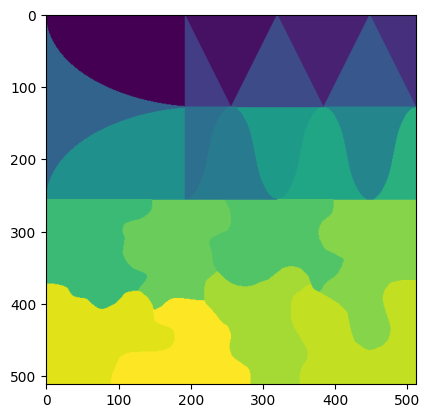

In [10]:
plt.figure()
plt.imshow(gt)

## compute upper bound of superpixel merging performance

In [11]:
ious = []
unique_superpixels = np.unique(rsuperpixels)
for gt_label in np.unique(gt):
    gt_mask = (gt == gt_label)  # ground truth mask
    gt_mask_size = np.sum(gt_mask)
    scores = []
    for sp_label in unique_superpixels:
        sp_mask = (rsuperpixels == sp_label)  # superpixel mask
        intersection = np.logical_and(gt_mask, sp_mask)
        inside = np.sum(intersection)
        outside = np.sum(sp_mask) - inside
        if outside == 0:
            scores.append(np.inf)
        else:
            scores.append(inside / outside)

    # argsort scores
    sorted_indices = reversed(np.argsort(scores, stable=True))
    mask_so_far = np.zeros_like(gt_mask)
    current_iou = 0
    for next_best_ind in sorted_indices:
        if scores[next_best_ind] < current_iou:
            break
        sp_label = unique_superpixels[next_best_ind]
        sp_mask = (rsuperpixels == sp_label)
        mask_so_far = np.logical_or(mask_so_far, sp_mask)
        intersection = np.logical_and(mask_so_far, gt_mask)
        union = np.logical_or(mask_so_far, gt_mask)
        current_iou = np.sum(intersection) / np.sum(union)
    ious.append(current_iou)
    print('gt label:', gt_label, 'iou:', current_iou, end='\r')
print('mean iou:', np.mean(ious))
# image ind = 0
# mean iou: 0.82872058885878264025974036 (c1 logits)
# mean iou: 0.83199464647340552727272737 (logits) <- logits without c1 seem to better
# image ind = 1
# mean iou: 0.942971797204369514006238 (logits)

mean iou: 0.942971797204369514006238


## compute sam2 performance without filtering any logit map

In [12]:
sam2_ious = []
for gt_label in np.unique(gt):
    gt_mask = (gt == gt_label)  # ground truth mask
    best_iou = 0
    for logit_channel in range(len(logits)):
        resized_logit = skimage.transform.resize(logits[logit_channel], gt.shape, order=1, anti_aliasing=False)
        intersection = np.logical_and(gt_mask, resized_logit > 0).sum()
        if intersection == 0:
            continue
        union = np.logical_or(gt_mask, resized_logit > 0).sum()
        current_iou = intersection / union  
        if current_iou > best_iou:
            best_iou = current_iou
    sam2_ious.append(best_iou)
    print('gt label:', gt_label, 'iou:', current_iou, end='\r')
print('mean iou:', np.mean(sam2_ious))
# image ind = 0
# mean iou: 0.61296344954377364343434343124 (with c1 logits)
# mean iou: 0.7757326059054758940298507436 @ 20 (with c1 logits)
# mean iou: 0.7566465898412257998905508655 @ 20 (without c1 logits)
# image ind = 1
# mean iou: 0.8729525485598967938300349255 @ 20 (logits)
# mean iou: 0.8703681061350197671711067255 (logits)





mean iou: 0.8703681061350197671711067255


### what happens if we reconstruct sam masks from the superpixels and run the evaluation again? it works slightly better!

In [4]:
approx_logits = []

for i in range(len(logits)):
    logit_mask = logits[i] > 0

    overlapping_superpixels = np.unique(superpixels[logit_mask])
    overlapping_superpixels_scores = []
    for overlapping_superpixel in overlapping_superpixels:
        mask = (superpixels == overlapping_superpixel)
        intersection = np.logical_and(mask, logit_mask)
        inside = np.sum(intersection)
        outside = np.sum(mask) - inside
        if outside == 0:
            overlapping_superpixels_scores.append(np.inf)
        else:
            overlapping_superpixels_scores.append(inside / outside)

    # argsort scores
    sorted_indices = reversed(np.argsort(overlapping_superpixels_scores, stable=True))
    mask_so_far = np.zeros_like(logit_mask)
    current_iou = 0
    for next_best_ind in sorted_indices:
        if overlapping_superpixels_scores[next_best_ind] < current_iou:
            break
        sp_label = overlapping_superpixels[next_best_ind]
        sp_mask = (superpixels == sp_label)
        mask_so_far = np.logical_or(mask_so_far, sp_mask)
        intersection = np.logical_and(mask_so_far, logit_mask)
        union = np.logical_or(mask_so_far, logit_mask)
        current_iou = np.sum(intersection) / np.sum(union)

    approx_logits.append(mask_so_far)
    print('logit ind:', i, 'iou:', current_iou, end='\r')
approx_logits = np.array(approx_logits)


In [14]:
sam2_ious_reconstructed = []
for gt_label in np.unique(gt):
    gt_mask = (gt == gt_label)  # ground truth mask
    best_iou = 0
    for logit_channel in range(len(approx_logits)):
        resized_logit = skimage.transform.resize(approx_logits[logit_channel], gt.shape, order=0, anti_aliasing=False)
        intersection = np.logical_and(gt_mask, resized_logit > 0).sum()
        if intersection == 0:
            continue
        union = np.logical_or(gt_mask, resized_logit > 0).sum()
        current_iou = intersection / union  
        if current_iou > best_iou:
            best_iou = current_iou
    sam2_ious_reconstructed.append(best_iou)
    print('gt label:', gt_label, 'iou:', current_iou, end='\r')
print('mean iou:', np.mean(sam2_ious_reconstructed))
# image ind = 0
# mean iou: 0.6201104374798151025641025644 (with c1 logits)
# mean iou: 0.786330471354893614189303152 @ 20 (with c1 logits)
# mean iou: 0.7798740362075728063492063576 @ 20 (without c1 logits)
# image ind = 1
# mean iou: 0.890725424797748622346368728 @ 20 (logits)
# mean iou: 0.889056189787779305477367728 (logits)

mean iou: 0.889056189787779305477367728


### consider only the best sam logits, we will use prior knowledge: the image is a partition, therefore the max iou allowed will be low, about 0.5, then we will keep logits by their predicted iou + stability score

In [9]:
import torch
def nms_masks(masks, scores, iou_threshold=0.97):
    """
    Perform Non-Maximum Suppression (NMS) on masks based on their scores.

    Args:
        masks (np.ndarray): Array of binary masks with shape (M, S, S).
        scores (np.ndarray): Array of scores with shape (M,).
        iou_threshold (float): IoU threshold for suppression.

    Returns:
        tuple: (kept_indices, kept_masks)
            - kept_indices: Original indices of masks that were kept
            - kept_masks: Array of binary masks after NMS with shape (K, S, S)
    """
    M, S, _ = masks.shape
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Convert masks and scores to torch tensors
    mf = torch.from_numpy(masks.reshape(M, -1)).float().to(device)
    scores = torch.from_numpy(scores).to(device)

    # Sort masks by scores in descending order
    sorted_indices = torch.argsort(scores, descending=True)
    mf = mf[sorted_indices]

    kept_indices = []
    
    while mf.shape[0] > 0:
        # Select the mask with the highest score
        current_mask = mf[0]
        kept_indices.append(sorted_indices[0].item())

        if mf.shape[0] == 1:
            break

        # Compute IoU of the current mask with the rest
        inters = torch.matmul(mf[1:], current_mask)
        areas = mf[1:].sum(dim=1) + current_mask.sum() - inters
        ious = inters / areas

        # Keep masks with IoU less than the threshold
        mask_to_keep = ious < iou_threshold
        mf = mf[1:][mask_to_keep]
        sorted_indices = sorted_indices[1:][mask_to_keep]

    # Return the indices first, then the binary masks
    return kept_indices



In [10]:
logits = np.load('tmp/logits.npy')
predicted_ious = np.load('tmp/predicted_ious.npy')
stability_scores = np.load('tmp/stability_scores.npy')

In [11]:
nms_logits = logits[nms_masks(logits > 0, (predicted_ious + stability_scores)/2, iou_threshold=0.5)] 
print('before', len(logits), 'after', len(nms_logits))

before 3072 after 449


##### compute sam2 performance of the nms logit maps

In [ ]:
for logits_to_evaluate in [nms_logits, logits[torch.argsort(torch.from_numpy((predicted_ious+ stability_scores)/2), descending=True)][:len(nms_logits)]]:
    sam2_ious = []
    print(f'resizing logits of shape {logits_to_evaluate.shape}...')
    resized_logits = [skimage.transform.resize(logit, gt.shape, order=1, anti_aliasing=False) for logit in logits_to_evaluate]
    print('calculating ious...')
    for gt_label in np.unique(gt):
        gt_mask = (gt == gt_label)  # ground truth mask
        best_iou = 0
        for resized_logit in resized_logits:
            intersection = np.logical_and(gt_mask, resized_logit > 0).sum()
            if intersection == 0:
                continue
            union = np.logical_or(gt_mask, resized_logit > 0).sum()
            current_iou = intersection / union  
            if current_iou > best_iou:
                best_iou = current_iou
        sam2_ious.append(best_iou)
        print('gt label:', gt_label, 'iou:', current_iou, end='\r')
    print('mean iou:', np.mean(sam2_ious))
# without NMS:
# image ind = 0
# mean iou: 0.61296344954377364343434343124 (with c1 logits)
# mean iou: 0.7757326059054758940298507436 @ 20 (with c1 logits)
# mean iou: 0.7566465898412257998905508655 @ 20 (without c1 logits)
# image ind = 1
# mean iou: 0.8729525485598967938300349255 @ 20 (logits)
# mean iou: 0.8703681061350197671711067255 (logits)

# with NMS:
# mean iou: 0.766325526624096189834480735 (logits, nms_thresh = 0.25)
# mean iou: 0.834306968099264352608335635 (logits, nms_thresh = 0.5)
# mean iou: 0.844281466592844591932676375 (logits, nms_thresh = 0.75)

# with simple score prioritization:
# mean iou: 0.2924722743826823603578020735 (logits, @ number logits nms_thresh = 0.25 which is 279)
# mean iou: 0.4475192137068337721077654526 (logits, @ number logits nms_thresh = 0.5 which is 449)
# mean iou: 0.7293950108463365467848726295 (logits, @ number logits nms_thresh = 0.75 which is 730)

# after visualization, it seems that score prioritization can not remove duplicates therefore it is very bad

resizing logits of shape (279, 256, 256)...
calculating ious...
mean iou: 0.766325526624096189834480735
resizing logits of shape (279, 256, 256)...
calculating ious...
mean iou: 0.2924722743826823603578020735


In [ ]:
# what if we do nms first and prioritization second? let's use nms 0.5 and take the best 279 
nms_indices = nms_masks(logits > 0, (predicted_ious + stability_scores)/2, iou_threshold=0.5)
mean_scores = (predicted_ious + stability_scores)/2
mean_scores = mean_scores[nms_indices]
sorted_indices = torch.argsort(torch.from_numpy(mean_scores), descending=True)
nms_indices = np.array(nms_indices)[sorted_indices][:279]

logits_to_evaluate = logits[nms_indices]
sam2_ious = []
print(f'resizing logits of shape {logits_to_evaluate.shape}...')
resized_logits = [skimage.transform.resize(logit, gt.shape, order=1, anti_aliasing=False) for logit in logits_to_evaluate]
print('calculating ious...')
for gt_label in np.unique(gt):
    gt_mask = (gt == gt_label)  # ground truth mask
    best_iou = 0
    for resized_logit in resized_logits:
        intersection = np.logical_and(gt_mask, resized_logit > 0).sum()
        if intersection == 0:
            continue
        union = np.logical_or(gt_mask, resized_logit > 0).sum()
        current_iou = intersection / union  
        if current_iou > best_iou:
            best_iou = current_iou
    sam2_ious.append(best_iou)
    print('gt label:', gt_label, 'iou:', current_iou, end='\r')
print('mean iou:', np.mean(sam2_ious))

# mean iou: 0.8190724310190941673209316876 (logits, nms_thresh @ 0.5 + prioritization of 279 best)
# this is better than 0.766 obtained with nms_thresh @ 0.25 which contained 279 logits
# therefore the optimal score hinges in a balance between nms first and prioritization second 
# let's work on the 279 mask number, which is the one we have optimized for the most (using only nms, only prioritization, and nms + prioritization)
# the baseline is then 0.819 



resizing logits of shape (279, 256, 256)...
calculating ious...
mean iou: 0.8190724310190941673209316876


In [13]:
approx_logits = []

for i in range(len(logits_to_evaluate)):
    logit_mask = logits_to_evaluate[i] > 0

    overlapping_superpixels = np.unique(superpixels[logit_mask])
    overlapping_superpixels_scores = []
    for overlapping_superpixel in overlapping_superpixels:
        mask = (superpixels == overlapping_superpixel)
        intersection = np.logical_and(mask, logit_mask)
        inside = np.sum(intersection)
        outside = np.sum(mask) - inside
        if outside == 0:
            overlapping_superpixels_scores.append(np.inf)
        else:
            overlapping_superpixels_scores.append(inside / outside)

    # argsort scores
    sorted_indices = reversed(np.argsort(overlapping_superpixels_scores, stable=True))
    mask_so_far = np.zeros_like(logit_mask)
    current_iou = 0
    for next_best_ind in sorted_indices:
        if overlapping_superpixels_scores[next_best_ind] < current_iou:
            break
        sp_label = overlapping_superpixels[next_best_ind]
        sp_mask = (superpixels == sp_label)
        mask_so_far = np.logical_or(mask_so_far, sp_mask)
        intersection = np.logical_and(mask_so_far, logit_mask)
        union = np.logical_or(mask_so_far, logit_mask)
        current_iou = np.sum(intersection) / np.sum(union)

    approx_logits.append(mask_so_far)
    print('logit ind:', i, 'iou:', current_iou, end='\r')
approx_logits = np.array(approx_logits)

sam2_ious_reconstructed = []
resized_logits = [skimage.transform.resize(approx_logits[logit_channel], gt.shape, order=0, anti_aliasing=False) for logit_channel in range(len(approx_logits))]
for gt_label in np.unique(gt):
    gt_mask = (gt == gt_label)  # ground truth mask
    best_iou = 0
    for resized_logit in resized_logits:
        intersection = np.logical_and(gt_mask, resized_logit > 0).sum()
        if intersection == 0:
            continue
        union = np.logical_or(gt_mask, resized_logit > 0).sum()
        current_iou = intersection / union  
        if current_iou > best_iou:
            best_iou = current_iou
    sam2_ious_reconstructed.append(best_iou)
    print('gt label:', gt_label, 'iou:', current_iou, end='\r')
print('mean iou:', np.mean(sam2_ious_reconstructed))

# again we surpass sam2 ious, that's surprising
# mean iou: 0.8351694232452328293182983786

mean iou: 0.8351694232452328293182983786


### can we do better with fancy binary tree merging? here we will create a partition, and because we know the original number of regions and the desired number of masks, we can compute the desired number of merges, which is basically their difference (original - desired)

In [ ]:
# save approx logits as targets for binary merging
np.save('tmp/approx_logits.npy', approx_logits)  # in fact we can use these ones

In [ ]:
tree_masks = np.load('tmp/tree_masks.npy').copy().astype(float)
for logits_to_evaluate in [tree_masks]:
    sam2_ious = []
    print(f'resizing logits of shape {logits_to_evaluate.shape}...')
    resized_logits = [skimage.transform.resize(logit, gt.shape, order=1, anti_aliasing=False) for logit in logits_to_evaluate]
    print('calculating ious...')
    for gt_label in np.unique(gt):
        gt_mask = (gt == gt_label)  # ground truth mask
        best_iou = 0
        for resized_logit in resized_logits:
            intersection = np.logical_and(gt_mask, resized_logit > 0).sum()
            if intersection == 0:
                continue
            union = np.logical_or(gt_mask, resized_logit > 0).sum()
            current_iou = intersection / union  
            if current_iou > best_iou:
                best_iou = current_iou
        sam2_ious.append(best_iou)
        print('gt label:', gt_label, 'iou:', current_iou, end='\r')
    print('mean iou:', np.mean(sam2_ious))

# mean iou: 0.573242890121155181462708182 @ 142 proposals, not actually good (way below 835)
# mean iou: 0.710278218040021281462708182 @ 268 proposals, not actually good (way below 835)
# (note that we tried to reconstruct the reconstructed logits with superpixels)

resizing logits of shape (268, 256, 256)...


calculating ious...
mean iou: 0.710278218040021281462708182


### ok binary merging didn't work, what if we ask for a partition from our reconstructed logits (it's kind of the same, but top down)
let us think for a second, what happens in the partition case? is greedy binary merging a good option maybe? oh, no, we can't really access the ground truth
given that we have the reconstructed logits, what would be a partition? maybe what results from pasting logits one over the other

279


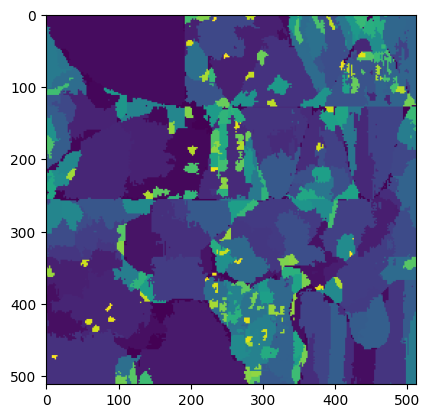

In [14]:
resized_logits = np.array([skimage.transform.resize(approx_logits[logit_channel], gt.shape, order=0, anti_aliasing=False) for logit_channel in range(len(approx_logits))])
areas = resized_logits.sum(axis=(1, 2))
resized_logits = resized_logits[np.argsort(areas, stable=True)[::-1]]
areas = resized_logits.sum(axis=(1, 2))
partition = np.zeros_like(resized_logits[0], dtype=int)    
label_number = 1
for logit in resized_logits:
    partition[logit > 0] = label_number
    label_number += 1
plt.figure()
plt.imshow(partition)
print(partition.max())



In [ ]:
# let us evaluate the partition
resized_logits = []
for label in range(partition.max() + 1):
    logit = -np.ones_like(partition, dtype=float)
    logit[partition == label] = 1
    resized_logits.append(logit)
resized_logits = np.array(resized_logits)

sam2_ious_reconstructed_partition = []
for gt_label in np.unique(gt):
    gt_mask = (gt == gt_label)  # ground truth mask
    best_iou = 0
    for resized_logit in resized_logits:
        intersection = np.logical_and(gt_mask, resized_logit > 0).sum()
        if intersection == 0:
            continue
        union = np.logical_or(gt_mask, resized_logit > 0).sum()
        current_iou = intersection / union  
        if current_iou > best_iou:
            best_iou = current_iou
    sam2_ious_reconstructed_partition.append(best_iou)
    print('gt label:', gt_label, 'iou:', current_iou, end='\r')
print('mean iou:', np.mean(sam2_ious_reconstructed_partition))

# mean iou: 0.231690911845240589219276464 (overlaid partition of reconstructed 3000+ logits)
# the partition of the reconstruction of the 3000+ logits is not good at all
# mean iou: 0.382660196368148724811755244 (overlaid reconstructed 279 logits)
# the partition of the reconstruction of the 279 logits is slightly better, but still pretty bad

mean iou: 0.382660196368148724811755244
